# Build QA for the 20% Data Challenge output files

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import os
import numpy as np
import warnings
from glob import glob

In [16]:
# Note that you need the standard desi/conda dependencies + matplotlib, 
# basemap, and healpy to run this notebook.
import fitsio
import matplotlib.pyplot as plt
from astropy.table import Table, vstack

In [4]:
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask
from desiutil.plots import init_sky, plot_sky_binned
from desiutil.log import get_logger

In [5]:
log = get_logger()

## Gather the targets and truth catalogs

In [6]:
topdir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'dc17b')

In [15]:
alltargfile = np.array(glob(os.path.join(topdir, '???', 'targets-*-*.fits')))
alltruthfile = np.char.replace(alltargfile, 'targets', 'truth')
print('Found {} target/truth catalogs in {}.'.format(len(alltargfile), topdir))

Found 6 target/truth catalogs in /Users/ioannis/research/projects/desi/datachallenge/dc17b.


In [18]:
targets = list()
truth = list()
for targfile, truthfile in zip(alltargfile, alltruthfile):
    targets.append(Table(fitsio.read(targfile, ext=1)))
    truth.append(Table(fitsio.read(truthfile, ext=1)))
targets = vstack(targets)
truth = vstack(truth)

In [20]:
targets[:3]

TARGETID,RA,DEC,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,BRICKNAME,DECAM_FLUX [6],WISE_FLUX [2],SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,DECAM_DEPTH [6],DECAM_GALDEPTH [6],EBV
int64,float64,float64,int64,int64,int64,float64,int32,bytes13,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
458535234755300976,203.837355444,1.13323652315,2305843009213693952,0,1,0.382254649986,7,2038p012,0.0 .. 0.0,3882.47 .. 2382.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0194478
2464562416344993999,203.853494801,1.12791251247,2305843009213693952,0,1,0.905721243068,7,2038p012,0.0 .. 0.0,47.1969 .. 29.7329,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0194478
335495350458137706,203.852904061,1.12901731141,2305843009213693952,0,1,0.690982475904,7,2038p012,0.0 .. 0.0,434.365 .. 266.408,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0194478


In [21]:
truth[:3]

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,DECAM_FLUX [6],WISE_FLUX [2],OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
int64,int64,int64,float32,bytes13,bytes13,bytes13,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32
458535234755300976,123,0,-6.96898e-05,STAR,STAR,,320,1771930393,15.828,55.8382 .. 5089.57,3883.06 .. 2382.63,-1.0,-1.0,3500.0,5.0,0.0
2464562416344993999,1098,0,1.7013e-05,STAR,STAR,,254,3877944323,18.5365,1.6907 .. 87.136,47.8508 .. 29.737,-1.0,-1.0,3300.0,5.0,-0.5
335495350458137706,18211,0,1.15561e-06,STAR,STAR,,320,4243734541,18.2082,6.22895 .. 568.328,433.725 .. 266.137,-1.0,-1.0,3500.0,5.0,0.0


In [22]:
skyfile = os.path.join(topdir, 'sky.fits')
log.info('Reading {}'.format(skyfile))
ff = fitsio.FITS(skyfile)
sky = ff[1].read(upper=True)

INFO:<ipython-input-22-75886509de91>:2:<module>: Reading /Users/ioannis/research/projects/desi/datachallenge/dc17b/sky.fits


In [23]:
stddarkfile = os.path.join(topdir, 'standards-dark.fits')
log.info('Reading {}'.format(stddarkfile))
ff = fitsio.FITS(stddarkfile)
stddark = ff[1].read(upper=True)

INFO:<ipython-input-23-f33ff087dd9c>:2:<module>: Reading /Users/ioannis/research/projects/desi/datachallenge/dc17b/standards-dark.fits


In [24]:
stdbrightfile = os.path.join(topdir, 'standards-bright.fits')
log.info('Reading {}'.format(stdbrightfile))
ff = fitsio.FITS(stdbrightfile)
stdbright = ff[1].read(upper=True)

INFO:<ipython-input-24-31571f85dc5c>:2:<module>: Reading /Users/ioannis/research/projects/desi/datachallenge/dc17b/standards-bright.fits


## Visualize the "observed" target densities

In [31]:
def qadensity(cat, objtype, targdens=None, max_bin_area=0.1):
    label = '{} (targets/deg$^2$)'.format(objtype)
    if targdens:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax = plt.subplots(1)
    ax = np.atleast_1d(ax)
       
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax[0]);
        data, area, _ = plot_sky_binned(cat['RA'], cat['DEC'], max_bin_area=max_bin_area,
                                        clip_lo='!1', cmap='jet', plot_type='healpix', 
                                        label=label, basemap=basemap)
        print(area)
    if targdens:
        dens = data.compressed()
        ax[1].hist(dens, bins=100, histtype='stepfilled', alpha=0.6, label='Observed {} Density'.format(objtype))
        if objtype in targdens.keys():
            ax[1].axvline(x=targdens[objtype], ls='--', color='k', label='Goal {} Density'.format(objtype))
        ax[1].set_xlabel(label)
        ax[1].set_ylabel('Number of Healpixels')
        ax[1].legend(loc='upper left', frameon=False)
        fig.subplots_adjust(wspace=0.2)

In [32]:
# Desired target densities, including contaminants.
targdens = {'ELG': 2400, 'LRG': 350, 'QSO': 260, 'SKY': 1400}

0.209823411303
0.209823411303
0.209823411303
0.209823411303
0.209823411303


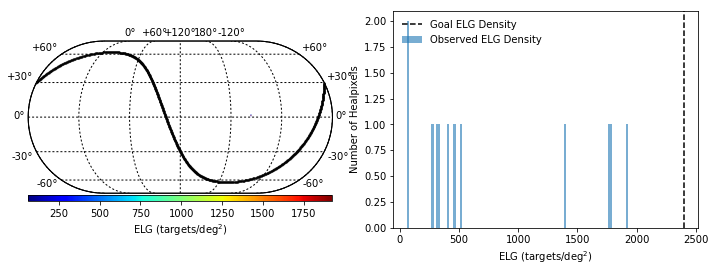

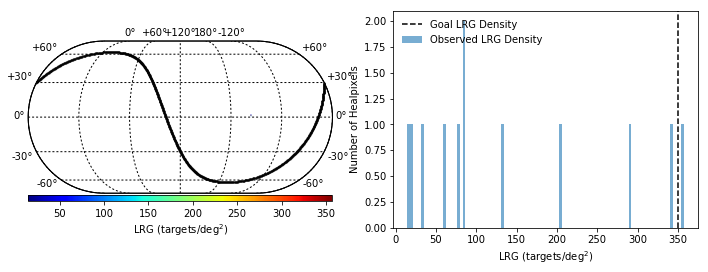

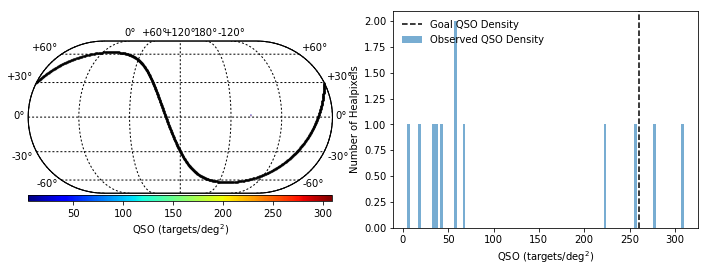

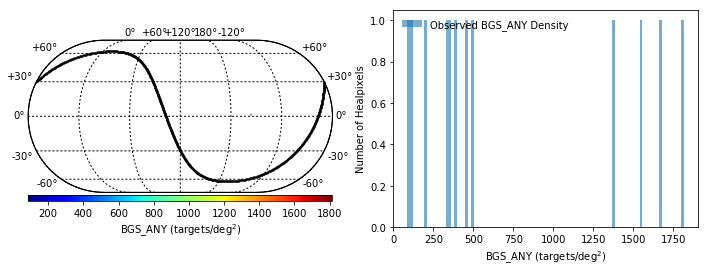

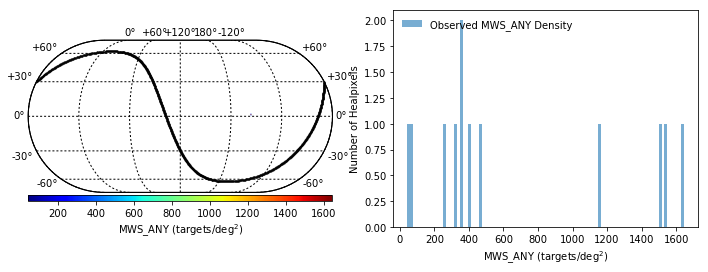

In [33]:
for obj in ('ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY'):
    these = np.where((targets['DESI_TARGET'] & desi_mask.mask(obj)) != 0)[0]
    qadensity(targets[these], obj, targdens)

0.209823411303
0.209823411303


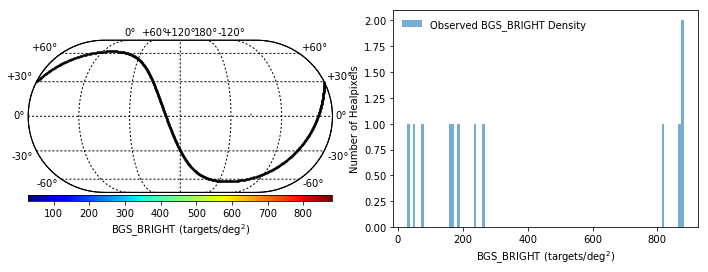

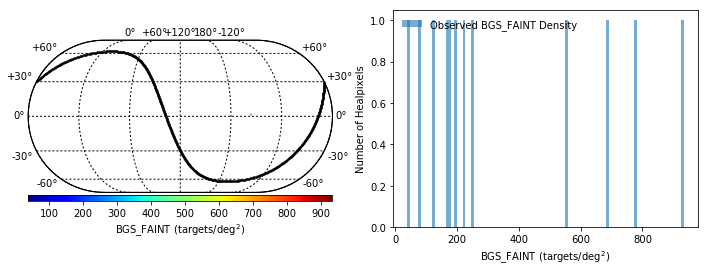

In [34]:
for obj in ('BGS_BRIGHT', 'BGS_FAINT'):
    these = np.where((targets['BGS_TARGET'] & bgs_mask.mask(obj)) != 0)[0]
    qadensity(targets[these], obj, targdens)

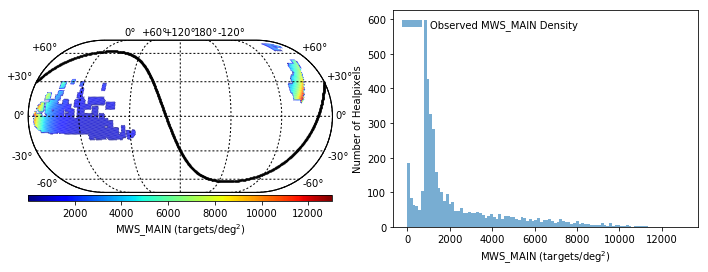

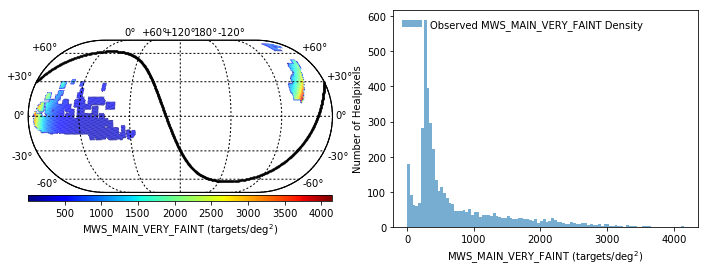

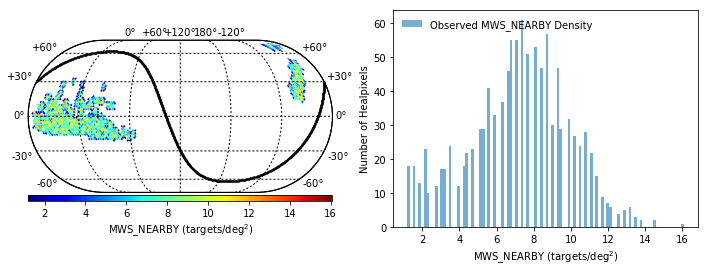

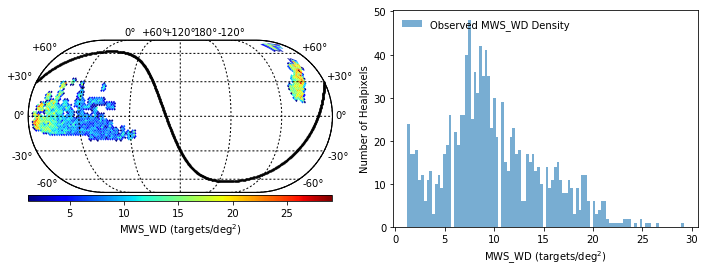

In [14]:
binarea = (2.0, 2.0, 10.0, 10.0) # [deg2]
for obj, area in zip( ('MWS_MAIN', 'MWS_MAIN_VERY_FAINT', 'MWS_NEARBY', 'MWS_WD'), binarea ):
    these = np.where((targets['MWS_TARGET'] & mws_mask.mask(obj)) != 0)[0]
    qadensity(targets[these], obj, targdens, max_bin_area=area)

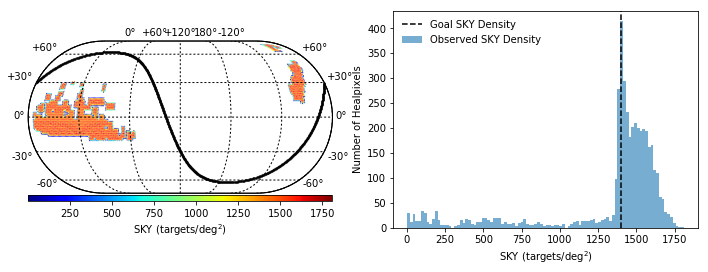

In [15]:
obj = 'SKY'
these = np.where((sky['DESI_TARGET'] & desi_mask.mask(obj)) != 0)[0]
qadensity(sky[these], obj, targdens)

## Visualize true targets and contaminants

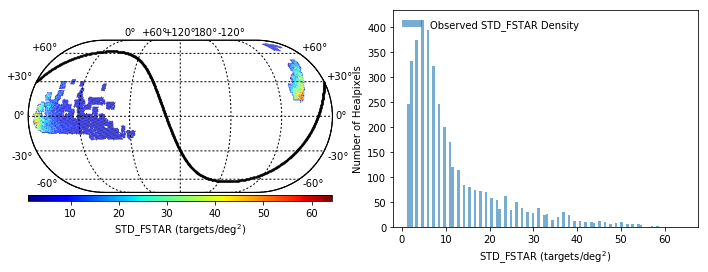

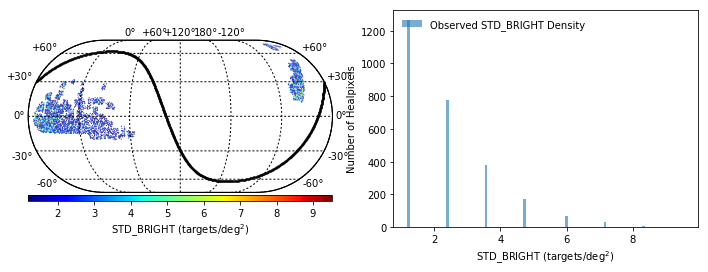

In [20]:
for cat, obj in zip( (stddark, stdbright), ('STD_FSTAR', 'STD_BRIGHT') ):
    these = np.where((cat['DESI_TARGET'] & desi_mask.mask(obj)) != 0)[0]
    qadensity(cat[these], obj, targdens)

In [16]:
def healpix_density(data):
    """Determine the target density given an input catalog using code 
    shamelessly taken from desiutil.plot.plot_sky_binned (by D. Kirkby).

    nside = 64 corresponds to about 0.210 deg2, about a factor of 3 smaller
    than the nominal imaging brick area (0.25x0.25=0.625 deg2), as determined 
    by this snippet of code:

      max_bin_area = 0.5
      for n in range(1, 10):
          nside = 2 ** n
          bin_area = hp.nside2pixarea(nside, degrees=True)
          print(nside, bin_area)
          if bin_area <= max_bin_area:
              break
    """
    import healpy as hp
        
    nside = 32
    npix = hp.nside2npix(nside)
    bin_area = hp.nside2pixarea(nside, degrees=True)

    pixels = hp.ang2pix(nside, np.radians(90 - data['DEC']), 
                        np.radians(data['RA']), nest=False)
    counts = np.bincount(pixels, weights=None, minlength=npix)
    dens = counts[np.flatnonzero(counts)] / bin_area
            
    return dens

In [17]:
def qso_density(targets, truth):
    """Determine the target density of QSOs (including contaminants)."""
    
    dens = dict()
    
    these = np.where(targets['DESI_TARGET'] & desi_mask.mask('QSO') != 0)[0]
    dens['QSO_TARGETS'] = healpix_density(targets[these])

    these = np.where((targets['DESI_TARGET'] & desi_mask.mask('QSO') != 0) * (truth['TRUEZ'] < 2.1))[0]
    dens['QSO_TRACER'] = healpix_density(targets[these])

    these = np.where((targets['DESI_TARGET'] & desi_mask.mask('QSO') != 0) * (truth['TRUEZ'] >= 2.1))[0]
    dens['QSO_LYA'] = healpix_density(targets[these])
    
    these = np.where((targets['DESI_TARGET'] & desi_mask.mask('QSO') != 0) * 
                     (truth['CONTAM_TARGET'] & contam_mask.mask('QSO_IS_GALAXY')) != 0)[0]
    dens['QSO_IS_GALAXY'] = healpix_density(targets[these])

    these = np.where((targets['DESI_TARGET'] & desi_mask.mask('QSO') != 0) * 
                     (truth['CONTAM_TARGET'] & contam_mask.mask('QSO_IS_STAR')) != 0)[0]
    dens['QSO_IS_STAR'] = healpix_density(targets[these])
    
    return dens

In [18]:
dens = qso_density(targets, truth)

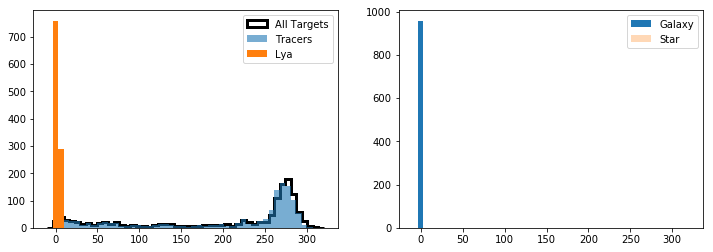

In [19]:
bins = 50
lim = (-10, 320)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(dens['QSO_TARGETS'], bins=bins, range=lim, label='All Targets', color='k', lw=3, histtype='step')
ax[0].hist(dens['QSO_TRACER'], bins=bins, range=lim, alpha=0.6, ls='--', lw=2, label='Tracers')#, histtype='step')
ax[0].hist(dens['QSO_LYA'], bins=bins, range=lim, lw=2, label='Lya')
ax[0].legend(loc='upper right')

ax[1].hist(dens['QSO_IS_GALAXY'], bins=bins, range=lim, label='Galaxy')
ax[1].hist(dens['QSO_IS_STAR'], bins=bins, range=lim, alpha=0.3, label='Star')
ax[1].legend(loc='upper right')

In [20]:
these = np.where((targets['DESI_TARGET'] & desi_mask.mask('QSO') != 0) * 
                 (truth['CONTAM_TARGET'] & contam_mask.mask('QSO_IS_GALAXY')) != 0)[0]
print(these)
print(len(these))
print(healpix_density(targets[these]))

[    1540     7970    14416 ..., 22185989 22215303 22260284]
2751
[ 0.29786953  0.29786953  0.59573905  0.59573905  0.89360858  0.89360858
  0.59573905  0.59573905  0.59573905  0.89360858  0.29786953  0.29786953
  0.59573905  0.89360858  0.29786953  0.59573905  0.29786953  0.29786953
  0.59573905  0.29786953  0.29786953  0.59573905  0.29786953  0.59573905
  0.29786953  0.29786953  0.89360858  0.29786953  0.29786953  0.59573905
  0.59573905  0.29786953  0.29786953  0.89360858  0.59573905  0.29786953
  0.89360858  0.29786953  1.1914781   0.89360858  0.89360858  0.59573905
  0.59573905  0.29786953  0.89360858  0.59573905  0.59573905  0.59573905
  0.59573905  0.59573905  0.89360858  0.59573905  0.59573905  0.29786953
  0.89360858  0.29786953  0.29786953  0.29786953  0.89360858  0.29786953
  0.29786953  0.29786953  0.29786953  0.59573905  0.89360858  0.59573905
  0.29786953  0.29786953  0.29786953  0.29786953  0.59573905  0.59573905
  0.29786953  0.29786953  0.59573905  0.59573905  0.297869

In [21]:
truth['TRUEZ'][these]

array([ 1.13998353,  0.83618766,  0.90073991, ...,  1.2298795 ,
        0.82990432,  1.1457963 ], dtype=float32)